### *Goal*

***we build a model to predict the '`Estimated time take for delivery`'***

***for a giveen delivery we have to predict the `total_delivery_seconds`***

**Start : `created_at`**
 
**End : `actaul_delivery_time`**

**target_varibale will be**
 
`total seconds value between 'created_at' and 'actaul_delivery_time'`

### Time features

1. `market_id`: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
2. `created_at`: Timestamp in UTC when the order was submitted by the consumer to DoorDash. 

*(Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)*

3. `actual_delivery_time`: Timestamp in UTC when the order was delivered to the consumer
Store features

4. `store_id`: an id representing the restaurant the order was submitted for
5. `store_primary_category`: cuisine category of the restaurant, e.g., italian, asian
6. `order_protocol`: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

### Order features

7. `total_items`: total number of items in the order
8. `subtotal`: total value of the order submitted (in cents)
9. `num_distinct_items`: number of distinct items included in the order
10. `min_item_price`: price of the item with the least cost in the order (in cents)
11. `max_item_price`: price of the item with the highest cost in the order (in cents)
### Market features

*DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of created_at (order submission time):*

12. `total_onshift_dashers`: Number of available dashers who are within 10 miles of the store at the time of order creation
13. `total_busy_dashers`: Subset of above total_onshift_dashers who are currently working on an order
14. `total_outstanding_orders`: Number of orders within 10 miles of this order that are currently being processed.


*We have predictions from other models for various stages of delivery process that we can use:*

15. `estimated_order_place_duration`: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
16. `estimated_store_to_consumer_driving_duration`: Estimated travel time between store and consumer (in seconds)

In [1]:
import sys 
sys.version

'3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")


In [64]:
color_coll =["#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6","#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6","#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6","#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6","#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6","#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6","#89CFF0", "#FF69B4", "#FFD700", "#7B68EE", "#FF4500",
          "#9370DB", "#32CD32", "#8A2BE2", "#FF6347", "#20B2AA",
          "#FF69B4", "#00CED1", "#FF7F50", "#7FFF00", "#DA70D6"]

In [3]:
data = pd.read_csv("dataset/historical_data.csv")
data.shape

(197428, 16)

In [4]:
df = data.copy()
df.shape

(197428, 16)

In [5]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [7]:
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [8]:
df.select_dtypes("object").nunique()

created_at                180985
actual_delivery_time      178110
store_primary_category        74
dtype: int64

<Axes: xlabel='market_id', ylabel='count'>

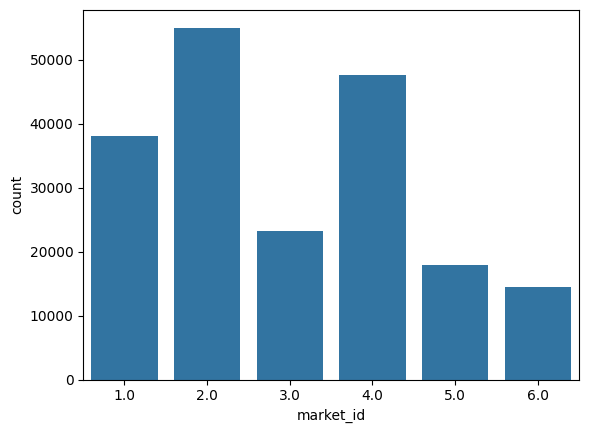

In [9]:
sns.countplot(df, x="market_id")

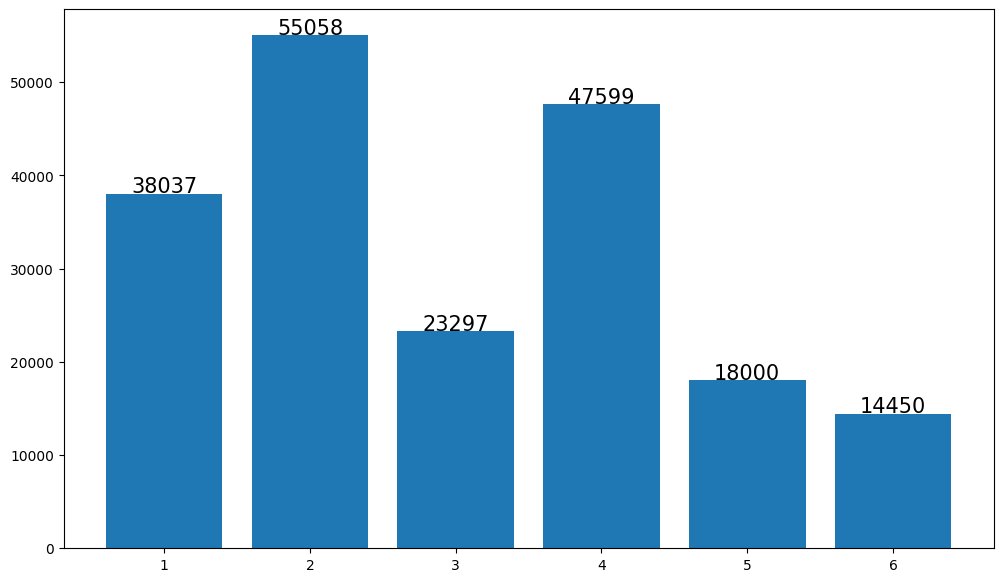

In [10]:
fig , ax = plt.subplots(figsize=(12,7))
ax.bar(df["market_id"].value_counts().index,df["market_id"].value_counts().values)
patches = ax.patches 
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2 
    y = patches[i].get_height() + 100
    ax.annotate(list(df["market_id"].value_counts().values)[i], (x,y), ha="center",fontsize=15)

**Converting `created_at` and `actual_delivery_time` to Datetime format**

In [11]:
df["created_at"].isna().sum()

0

In [12]:
df["actual_delivery_time"].isna().sum()

7

In [13]:
df.dropna(subset=["actual_delivery_time"],inplace=True)

In [14]:
df["actual_delivery_time"].isna().sum()

0

In [15]:
df["created_at"] = pd.to_datetime(df["created_at"])
df["created_at"].dtypes

dtype('<M8[ns]')

In [16]:
print(df["actual_delivery_time"].dtypes)

df["actual_delivery_time"] = pd.to_datetime(df["actual_delivery_time"])
print(df["actual_delivery_time"].dtypes)

object
datetime64[ns]


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197421 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196434 non-null  float64       
 1   created_at                                    197421 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197421 non-null  int64         
 4   store_primary_category                        192661 non-null  object        
 5   order_protocol                                196426 non-null  float64       
 6   total_items                                   197421 non-null  int64         
 7   subtotal                                      197421 non-null  int64         
 8   num_distinct_items                            197421 non-nu

In [18]:
df["store_primary_category"].nunique()

74

In [19]:
df["store_primary_category"].isna().sum()

4760

<Axes: ylabel='store_primary_category'>

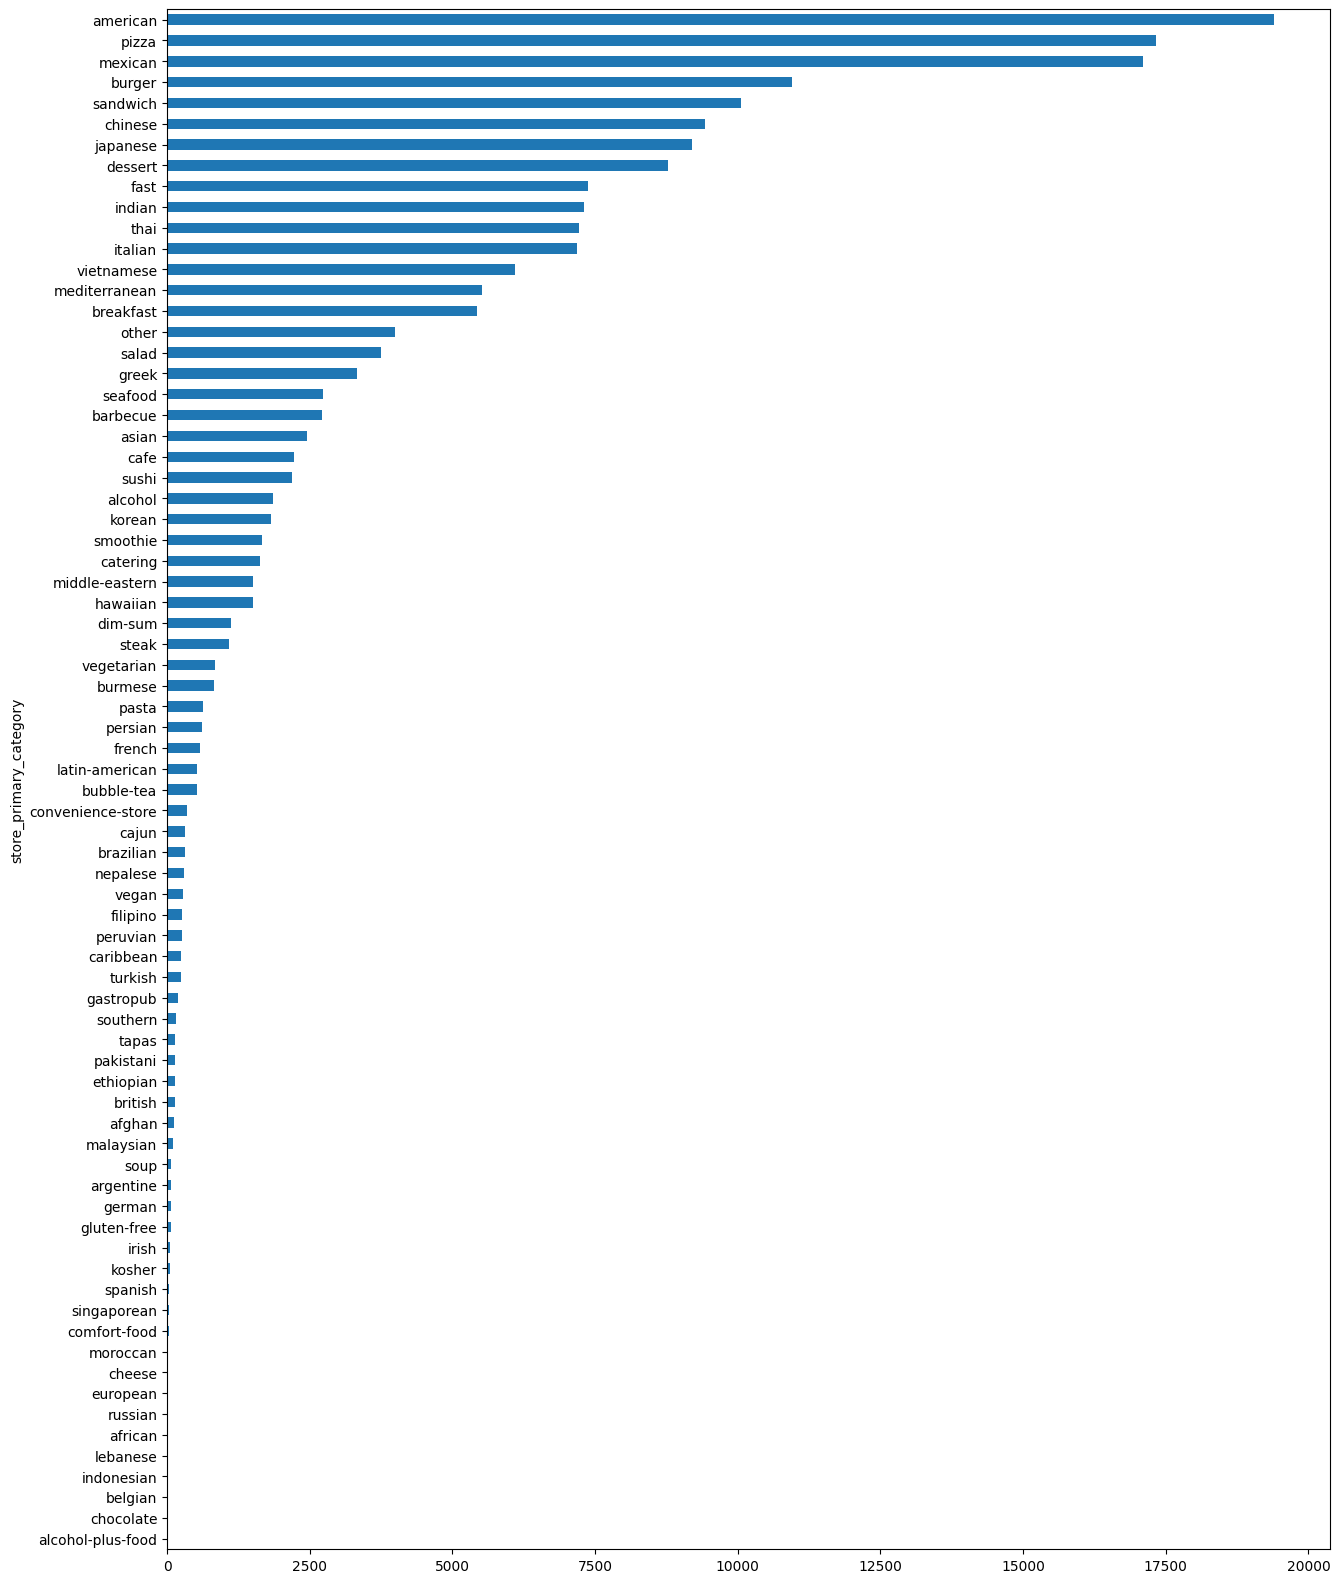

In [20]:
plt.subplots(figsize=(15,20))
df["store_primary_category"].value_counts().sort_values(ascending=True).plot(kind="barh")

In [21]:
store_primary = df.groupby(["store_primary_category"])["subtotal"].sum().sort_values(ascending=True)
store_primary

store_primary_category
alcohol-plus-food        1699
chocolate                2650
indonesian               3240
belgian                  3780
african                 26997
                       ...   
chinese              27021933
japanese             30902830
mexican              39247595
american             51572367
pizza                52090143
Name: subtotal, Length: 74, dtype: int64

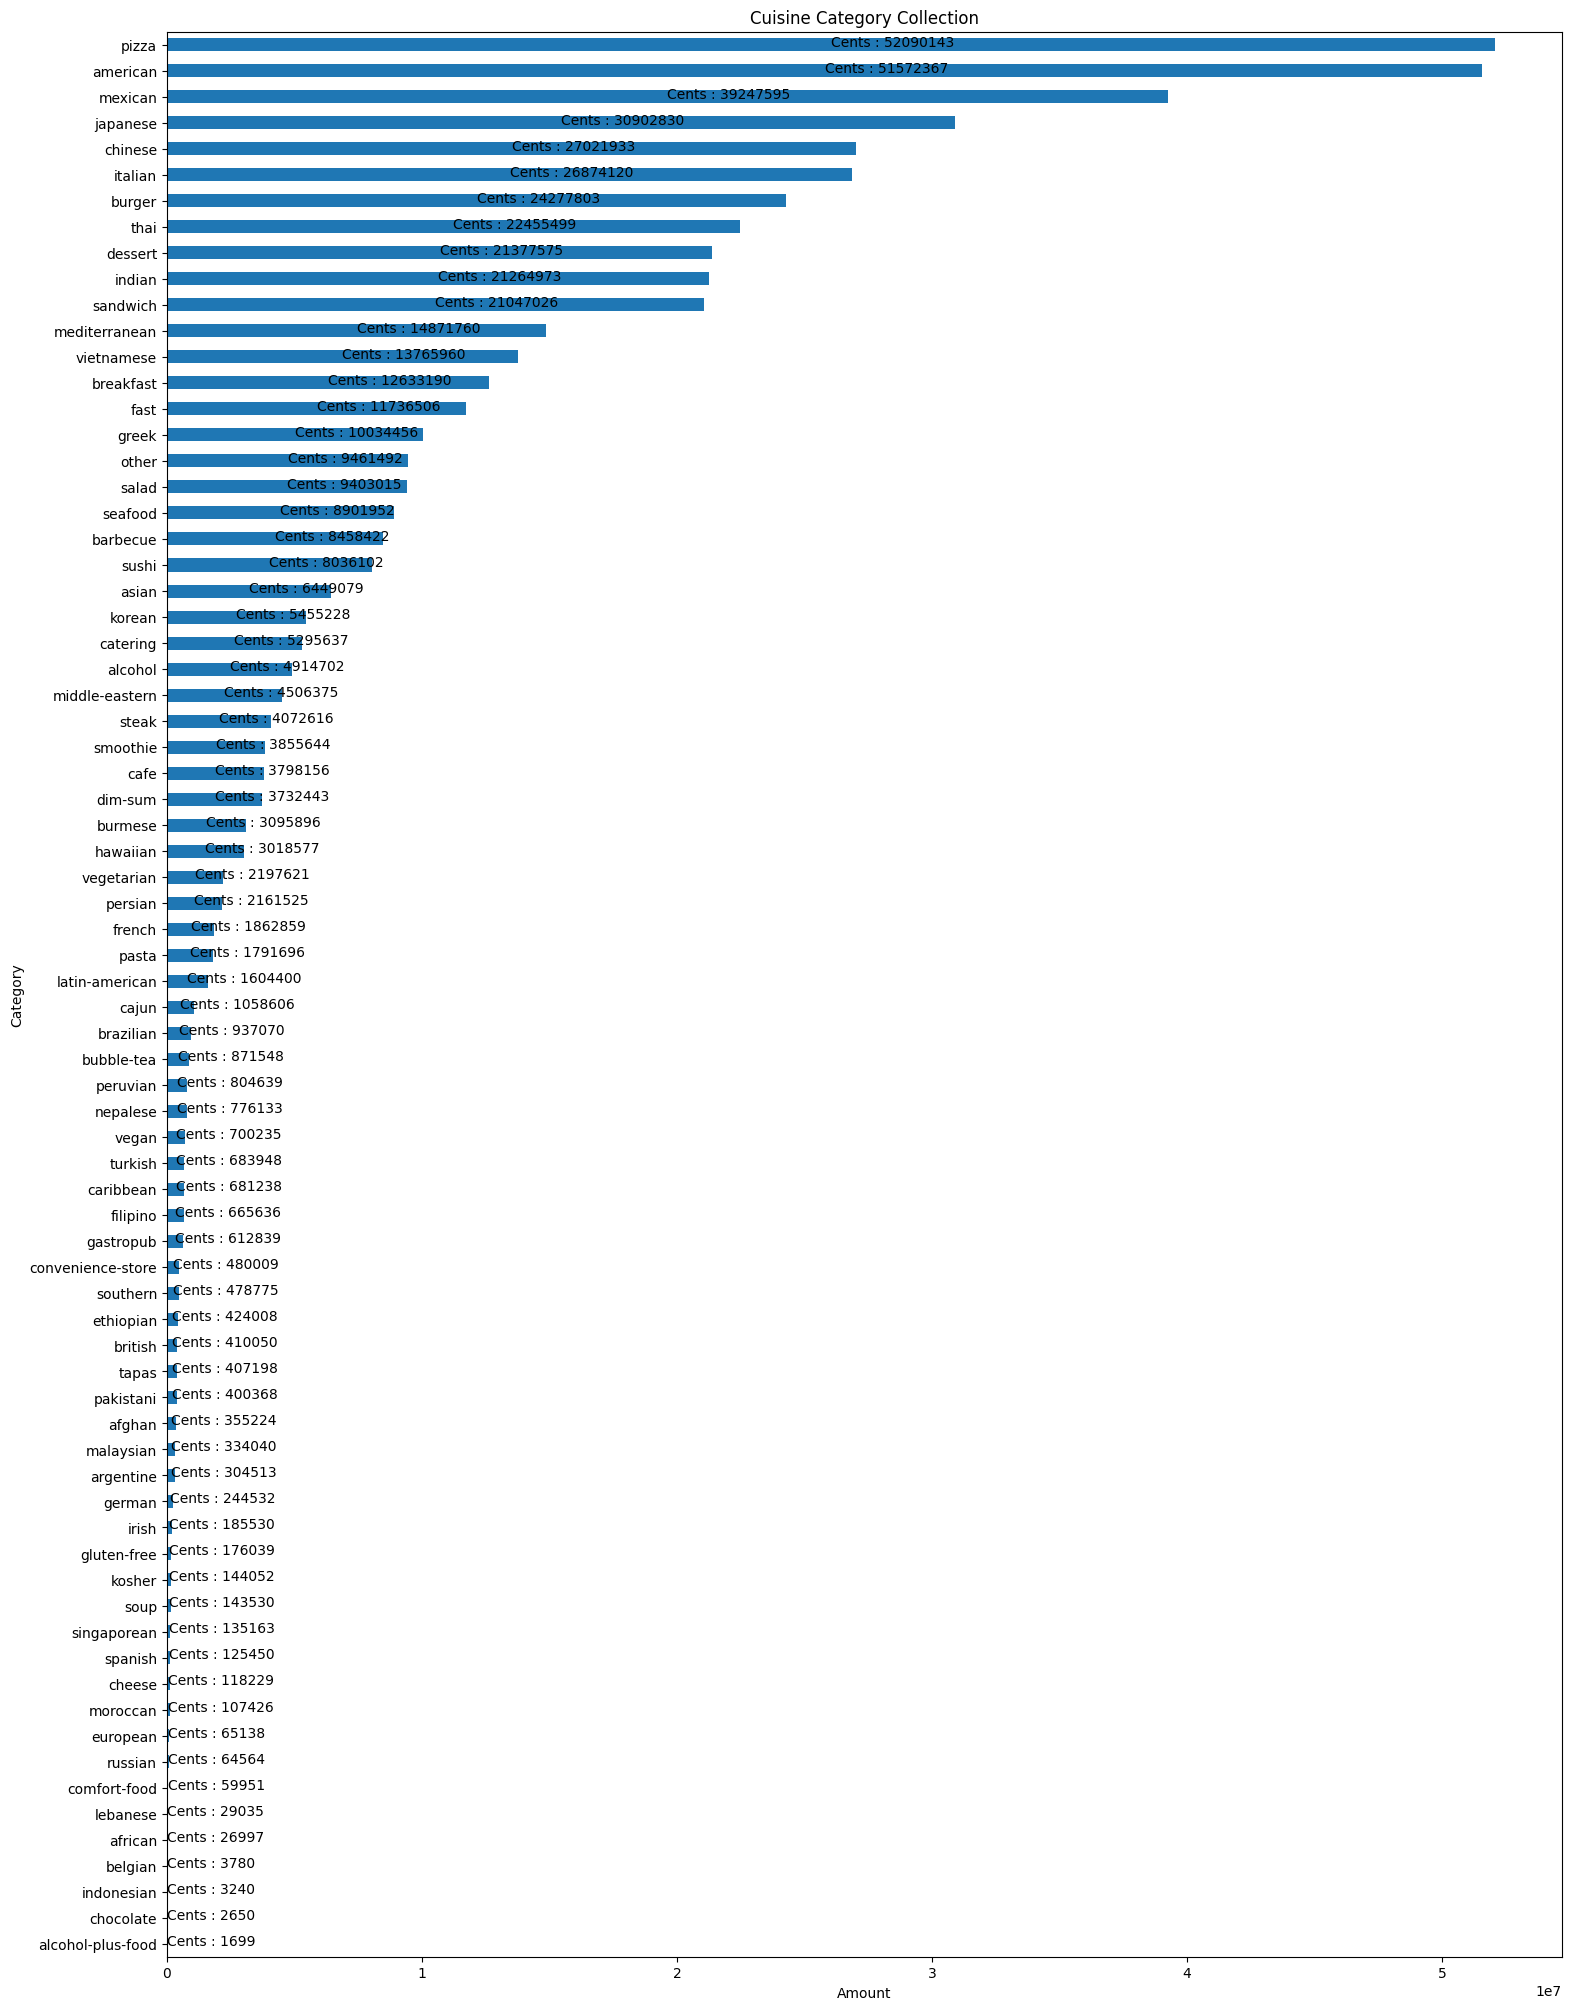

In [66]:
fig , ax = plt.subplots(figsize=(18,25))
df.groupby(["store_primary_category"])["subtotal"].sum().sort_values(ascending=True).plot(kind='barh')

patches = ax.patches 
for i in range(len(patches)):
    x = patches[i].get_width() /2
    y = patches[i].get_y() + patches[i].get_height() / 2.5
    ax.annotate(f"Cents : {store_primary.values[i]}", (x,y), ha='left',fontsize=10,color='black')
    ax.set(title="Cuisine Category Collection",ylabel="Category",xlabel="Amount")


In [23]:
store_primary_df = df[df["store_primary_category"].isna()]
store_primary_df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,NaN,1.0,3,5000,3,1500,1900,2.0,2.0,2.0,446,338.0
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,NaN,1.0,2,3900,2,1200,2700,10.0,9.0,9.0,446,638.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197210,1.0,2015-02-15 02:17:39,2015-02-15 03:21:16,2177,NaN,1.0,3,2800,3,700,1400,24.0,22.0,25.0,446,582.0
197211,1.0,2015-02-03 01:58:27,2015-02-03 02:32:07,2177,NaN,1.0,2,1400,2,700,700,22.0,22.0,24.0,446,449.0
197212,1.0,2015-02-12 02:42:13,2015-02-12 03:39:29,2177,NaN,1.0,5,2800,5,300,700,28.0,28.0,21.0,446,800.0
197259,NaN,2015-02-10 01:32:37,2015-02-10 02:02:09,1340,NaN,NaN,1,849,1,849,849,25.0,13.0,20.0,251,1013.0


In [24]:
store_primary_df["market_id"].value_counts()

market_id
2.0    1095
4.0     964
1.0     589
5.0     589
3.0     576
6.0     455
Name: count, dtype: int64

In [25]:
df["subtotal"].idxmax()

82763

In [26]:
df[df["subtotal"] == df["subtotal"].max()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
82763,6.0,2015-02-12 01:28:39,2015-02-12 03:39:57,3552,japanese,1.0,27,27100,19,200,3000,NaN,NaN,NaN,446,291.0


In [27]:
df.sort_values("subtotal", ascending=False)[:10]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
82763,6.0,2015-02-12 01:28:39,2015-02-12 03:39:57,3552,japanese,1.0,27,27100,19,200,3000,NaN,NaN,NaN,446,291.0
188378,1.0,2015-01-27 02:11:51,2015-01-27 03:35:26,1227,vietnamese,5.0,25,26800,13,200,1800,13.0,14.0,17.0,251,745.0
71702,6.0,2015-01-27 02:22:26,2015-01-27 03:47:09,5186,catering,3.0,18,24300,14,600,2200,NaN,NaN,NaN,251,716.0
96456,1.0,2015-02-04 19:21:43,2015-02-04 20:20:25,790,italian,5.0,17,22500,14,450,1750,18.0,17.0,21.0,251,461.0
53072,1.0,2015-02-05 01:02:41,2015-02-05 02:25:20,5452,pizza,5.0,20,20350,14,450,1250,7.0,8.0,11.0,251,344.0
83330,6.0,2015-01-28 02:12:01,2015-01-28 03:50:48,3552,japanese,1.0,20,19650,12,200,2000,NaN,NaN,NaN,446,620.0
73129,4.0,2015-02-10 01:42:46,2015-02-10 02:36:05,1448,vietnamese,1.0,11,19250,11,200,3100,75.0,67.0,92.0,446,310.0
171276,4.0,2015-02-02 17:46:21,2015-02-02 18:46:36,5967,greek,3.0,16,18920,4,695,1695,10.0,11.0,14.0,251,659.0
8994,1.0,2015-01-27 20:08:26,2015-01-27 21:21:37,3494,salad,1.0,21,18370,11,350,1380,13.0,13.0,12.0,446,787.0
173912,6.0,2015-02-13 16:29:21,2015-02-13 18:27:58,3923,sandwich,4.0,17,17810,14,375,1295,NaN,NaN,NaN,251,126.0


In [28]:
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [29]:
new_df = df.dropna(axis=0,how='any',inplace=False)

In [30]:
new_df.shape , df.shape

((175777, 16), (197421, 16))

In [31]:
new_df.shape[0] - df.shape[0]

-21644

In [32]:
new_df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
dtype: int64

In [33]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175777 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175777 non-null  float64       
 1   created_at                                    175777 non-null  datetime64[ns]
 2   actual_delivery_time                          175777 non-null  datetime64[ns]
 3   store_id                                      175777 non-null  int64         
 4   store_primary_category                        175777 non-null  object        
 5   order_protocol                                175777 non-null  float64       
 6   total_items                                   175777 non-null  int64         
 7   subtotal                                      175777 non-null  int64         
 8   num_distinct_items                            175777 non-nu

In [34]:
new_df["actual_time_for_delivery"] = new_df["actual_delivery_time"] - new_df["created_at"]
new_df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_time_for_delivery
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,0 days 01:02:59
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,0 days 01:07:04
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,0 days 00:26:26
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,0 days 00:37:53
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,0 days 00:49:48


In [35]:
new_df["actual_time_for_delivery"] = new_df["actual_time_for_delivery"].dt.total_seconds()
new_df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_time_for_delivery
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0


In [36]:
new_df[new_df["actual_time_for_delivery"] < 0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_time_for_delivery


In [37]:
new_df.describe()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_time_for_delivery
count,175777.000000,175777,175777,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000
mean,2.743726,2015-02-04 19:57:50.009631744,2015-02-04 20:45:36.432303616,3556.299561,2.911752,3.204976,2697.111147,2.675060,684.965433,1160.158616,44.918664,41.861381,58.230115,307.818105,546.077240,2866.422672
min,1.000000,2015-01-21 15:22:03,2015-01-21 16:16:34,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,101.000000
25%,2.000000,2015-01-29 01:31:19,2015-01-29 02:18:30,1703.000000,1.000000,2.000000,1412.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,251.000000,384.000000,2105.000000
50%,2.000000,2015-02-05 02:41:26,2015-02-05 03:45:31,3620.000000,3.000000,3.000000,2224.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,251.000000,544.000000,2662.000000
75%,4.000000,2015-02-12 01:04:32,2015-02-12 01:47:32,5341.000000,4.000000,4.000000,3410.000000,3.000000,942.000000,1395.000000,66.000000,63.000000,85.000000,446.000000,703.000000,3383.000000
max,6.000000,2015-02-18 06:00:44,2015-02-19 22:45:31,6987.000000,7.000000,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,373879.000000
std,1.330963,NaN,NaN,2055.959006,1.513128,2.674055,1828.554893,1.625681,519.882924,560.828571,34.544724,32.168505,52.731043,89.796587,218.717798,1660.741001


In [38]:
new_df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'actual_time_for_delivery'],
      dtype='object')

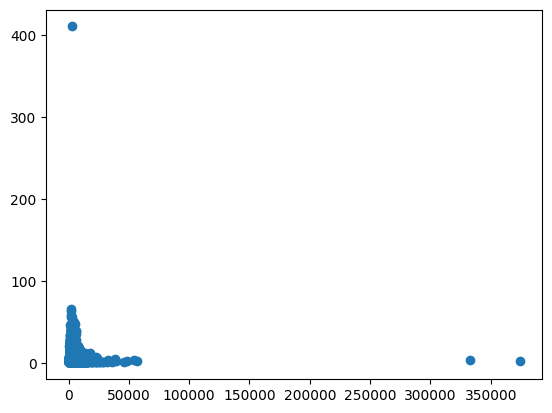

In [39]:
plt.scatter(new_df['actual_time_for_delivery'],new_df['total_items'])

In [40]:
new_df['total_items'].unique()

array([  4,   1,   2,   3,   5,   7,  10,   6,   9,   8,  13,  16,  12,
        25,  17,  11,  24,  30,  14,  31,  35,  40,  26,  28,  21,  20,
        15,  19,  18,  23,  29,  34,  42,  22,  56,  36,  57,  39,  47,
        45,  38,  33,  27,  41, 411,  32,  59,  51,  37,  48,  44,  49,
        64,  66], dtype=int64)

In [41]:
new_df['actual_time_for_delivery'].max()

373879.0

<Axes: ylabel='actual_time_for_delivery'>

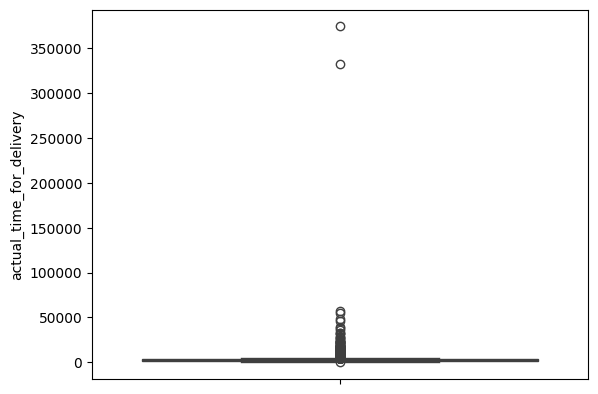

In [42]:
sns.boxplot(new_df["actual_time_for_delivery"])

In [43]:
new_df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_time_for_delivery
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0


In [46]:
new_df["total_onshift_dashers"].unique()

array([ 33.,   1.,   8.,   5.,   4.,   6.,  24.,  12.,  19.,  21.,  22.,
        16.,  27.,  13., 117., 130., 121.,  34.,  18.,  17.,  38.,  20.,
        15.,  39.,  26.,  30.,  35.,  11.,  14.,  32.,  29.,  25.,  23.,
        61.,  41.,  58.,  51.,  57.,  60.,   7.,   3.,   2.,   9., 108.,
        72.,  89., 112.,  55., 126.,  80.,  69., 125., 113., 105.,  98.,
        86.,  90.,  87.,  74.,  84.,  91.,  96., 123., 101., 119., 129.,
        66.,  81.,  75.,  43.,  70.,  65.,  77., 114.,  62., 116., 102.,
        76.,  67.,  64.,  88.,  73.,  63.,  46.,  28.,  36.,  47., 110.,
        97.,  42.,  79.,  49.,  50.,  37.,  92., 103.,  44.,  68.,  56.,
         0., 107.,  94.,  78.,  71., 128., 104.,  45.,  31., 100.,  53.,
        40., 115., 109.,  99.,  85.,  59., 118.,  10.,  54.,  52.,  48.,
       132., 127., 133., 131., 149.,  93., 111.,  95.,  82., 136., 120.,
       134., 124., 106., 137.,  83., 152., 147., 144., 150., 145., 122.,
       155., 135., 151., 140., 141., 143., 138., 13

In [47]:
new_df["total_onshift_dashers"].max()

171.0

In [48]:
new_df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'actual_time_for_delivery'],
      dtype='object')

In [49]:
new_df.groupby(["total_onshift_dashers","total_busy_dashers","subtotal"])["actual_time_for_delivery"].apply(lambda x : x).reset_index()

,total_onshift_dashers,total_busy_dashers,subtotal,level_3,actual_time_for_delivery
0,-4.0,7.0,1934,179225,2835.0
1,-3.0,0.0,1117,60282,2437.0
2,-2.0,-1.0,1874,119242,4703.0
3,-2.0,1.0,720,188333,4153.0
4,-2.0,2.0,1980,119246,2368.0
...,...,...,...,...,...
175772,164.0,86.0,5062,140992,2782.0
175773,165.0,97.0,1499,100018,2397.0
175774,168.0,131.0,1524,190274,3016.0
175775,169.0,134.0,1074,170897,3884.0


In [50]:
new_df[['total_onshift_dashers','total_busy_dashers','actual_time_for_delivery']].sort_values(by=["actual_time_for_delivery"],ascending=False)

,total_onshift_dashers,total_busy_dashers,actual_time_for_delivery
185550,0.0,0.0,373879.0
27189,72.0,68.0,332482.0
83055,109.0,102.0,57032.0
190860,71.0,70.0,54447.0
86952,19.0,19.0,48178.0
...,...,...,...
117928,52.0,54.0,325.0
42507,55.0,43.0,321.0
30562,67.0,58.0,297.0
862,60.0,74.0,223.0


In [51]:
new_df["busy_dasher_ratio"] = new_df["total_onshift_dashers"] / new_df["total_busy_dashers"]
new_df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_time_for_delivery,busy_dasher_ratio
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,2.357143
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,0.500000
8,2.0,2015-02-16 00:11:35,2015-02-16 00:38:01,5477,indian,3.0,4,4771,3,820,1604,8.0,6.0,18.0,446,289.0,1586.0,1.333333
14,1.0,2015-02-12 03:36:46,2015-02-12 04:14:39,2841,italian,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,446,795.0,2273.0,0.833333
15,1.0,2015-01-27 02:12:36,2015-01-27 03:02:24,2841,italian,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,446,205.0,2988.0,1.000000


In [52]:
new_df[['total_onshift_dashers','total_busy_dashers','busy_dasher_ratio','actual_time_for_delivery']].sort_values(by=["actual_time_for_delivery"],ascending=False)


,total_onshift_dashers,total_busy_dashers,busy_dasher_ratio,actual_time_for_delivery
185550,0.0,0.0,NaN,373879.0
27189,72.0,68.0,1.058824,332482.0
83055,109.0,102.0,1.068627,57032.0
190860,71.0,70.0,1.014286,54447.0
86952,19.0,19.0,1.000000,48178.0
...,...,...,...,...
117928,52.0,54.0,0.962963,325.0
42507,55.0,43.0,1.279070,321.0
30562,67.0,58.0,1.155172,297.0
862,60.0,74.0,0.810811,223.0


In [59]:
new_df.loc[27189]

market_id                                                       1.0
created_at                                      2015-02-16 02:24:09
actual_delivery_time                            2015-02-19 22:45:31
store_id                                                       4338
store_primary_category                                       indian
order_protocol                                                  3.0
total_items                                                       4
subtotal                                                       4980
num_distinct_items                                                4
min_item_price                                                  995
max_item_price                                                 1795
total_onshift_dashers                                          72.0
total_busy_dashers                                             68.0
total_outstanding_orders                                      104.0
estimated_order_place_duration                  

In [60]:
new_df.loc[83055]

market_id                                                       2.0
created_at                                      2015-02-01 02:18:07
actual_delivery_time                            2015-02-01 18:08:39
store_id                                                        355
store_primary_category                                       burger
order_protocol                                                  4.0
total_items                                                       3
subtotal                                                       2379
num_distinct_items                                                2
min_item_price                                                  389
max_item_price                                                  695
total_onshift_dashers                                         109.0
total_busy_dashers                                            102.0
total_outstanding_orders                                      163.0
estimated_order_place_duration                  

In [53]:
# df.drop(new_df[new_df['total_onshift_dashers'] < 0].index)

<Axes: xlabel='actual_time_for_delivery', ylabel='Density'>

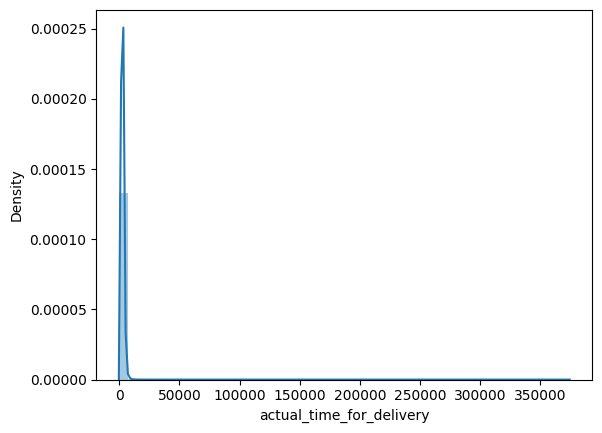

In [58]:
sns.distplot(new_df['actual_time_for_delivery'])

In [67]:
new_df.describe()

,market_id,created_at,actual_delivery_time,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_time_for_delivery,busy_dasher_ratio
count,175777.000000,175777,175777,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,1.722740e+05
mean,2.743726,2015-02-04 19:57:50.009631744,2015-02-04 20:45:36.432303616,3556.299561,2.911752,3.204976,2697.111147,2.675060,684.965433,1160.158616,44.918664,41.861381,58.230115,307.818105,546.077240,2866.422672,NaN
min,1.000000,2015-01-21 15:22:03,2015-01-21 16:16:34,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,101.000000,-inf
25%,2.000000,2015-01-29 01:31:19,2015-01-29 02:18:30,1703.000000,1.000000,2.000000,1412.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,251.000000,384.000000,2105.000000,1.000000e+00
50%,2.000000,2015-02-05 02:41:26,2015-02-05 03:45:31,3620.000000,3.000000,3.000000,2224.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,251.000000,544.000000,2662.000000,1.038462e+00
75%,4.000000,2015-02-12 01:04:32,2015-02-12 01:47:32,5341.000000,4.000000,4.000000,3410.000000,3.000000,942.000000,1395.000000,66.000000,63.000000,85.000000,446.000000,703.000000,3383.000000,1.207317e+00
max,6.000000,2015-02-18 06:00:44,2015-02-19 22:45:31,6987.000000,7.000000,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,373879.000000,inf
std,1.330963,NaN,NaN,2055.959006,1.513128,2.674055,1828.554893,1.625681,519.882924,560.828571,34.544724,32.168505,52.731043,89.796587,218.717798,1660.741001,NaN


<Axes: xlabel='market_id', ylabel='Count'>

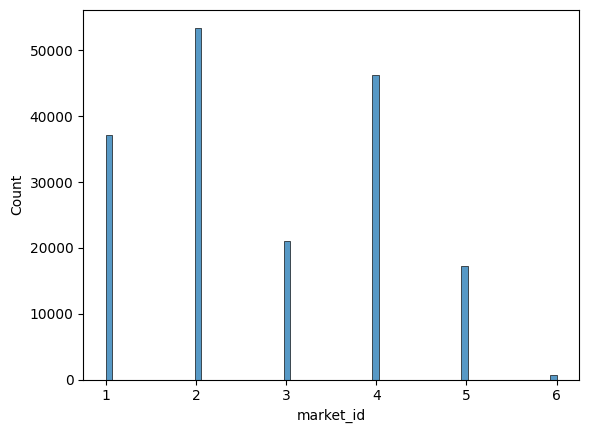

In [72]:
sns.histplot(new_df["market_id"])

<Axes: xlabel='store_id', ylabel='Count'>

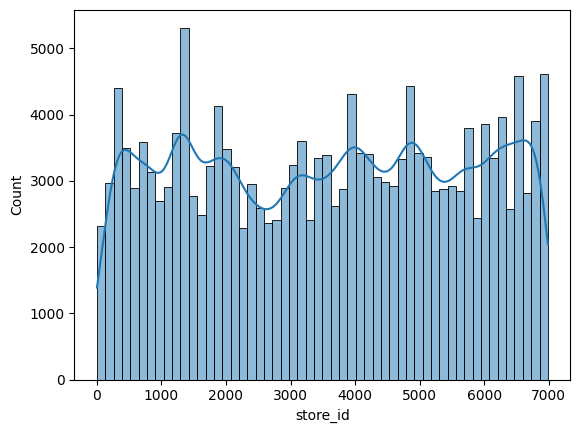

In [78]:

sns.histplot(new_df["store_id"],kde=True)